# Labs Access Analysis: 04 Enrich Data Facebook

## Setup

In [37]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import os
import gc
sns.set()
#sns.set_style("whitegrid") # Seaborn style

In [2]:
# Load data, csv
data_csv = pd.read_csv('data/labs.csv')
data_csv['Lat'] = data_csv['Lat'].astype(float)
data_csv['Long'] = data_csv['Long'].astype(float)
data_csv = data_csv[(((~data_csv.Lat.isnull()) & (~data_csv.Long.isnull())))]

In [3]:
data_labs = gpd.GeoDataFrame(
    data_csv,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(data_csv.Long, data_csv.Lat))

In [4]:
data_labs.explore()

In [5]:
isochrones = pd.read_json("data/isochrones.json")

## transform data for geodataframe

In [6]:
isochrones['longitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][0])
isochrones['latitude'] = isochrones['metadata'].apply(lambda x: x['query']['locations'][0][1])
isochrones['area_units'] = isochrones['metadata'].apply(lambda x: x['query']['area_units'])

In [7]:
isochrones['total_pop'] = isochrones['features'].apply(lambda x: x[0]['properties']['total_pop'])
isochrones['area'] = isochrones['features'].apply(lambda x:x[0]['properties']['area'])
isochrones['reachfactor'] = isochrones['features'].apply(lambda x: x[0]['properties']['reachfactor'])

In [8]:
isochrones['coordinates'] = isochrones['features'].apply(lambda x: x[0]['geometry']['coordinates'])
isochrones['geometry_type'] = isochrones['features'].apply(lambda x: x[0]['geometry']['type'])

In [9]:
isochrones['geometry'] = isochrones['coordinates'].apply(lambda x: Polygon(x[0]))

In [10]:
isochrones = isochrones[['name','longitude','latitude','total_pop','area','reachfactor','geometry']]

In [11]:
isochrones = gpd.GeoDataFrame(
    isochrones,
    geometry=isochrones.geometry,
    crs='EPSG:4326')

In [12]:
isochrones.explore()

In [13]:
isochrones.to_file("data/lab_isochrones.geojson",driver='GeoJSON')

In [14]:
labs = isochrones.sjoin(data_labs, how='inner')

In [15]:
del labs['name']
del labs['index_right']
del labs['Lat']
del labs['Long']

In [16]:
columns = {
    'Name': 'name',
    'Type': 'type',
    'City': 'city',
    'Cluster':  'cluster',
    'Address': 'address',
    'CAP': 'zipcode',
    'Source': 'source',
    'URL': 'url',
    'Notes': 'notes'
}

In [17]:
labs.rename(columns=columns, inplace=True)

In [18]:
labs.to_file("data/labs_isochrones.geojson",driver='GeoJSON')

# Load facebook data

Spain

[https://data.humdata.org/dataset/spain-high-resolution-population-density-maps-demographic-estimates](https://data.humdata.org/dataset/spain-high-resolution-population-density-maps-demographic-estimates)

Italy

[https://data.humdata.org/dataset/italy-high-resolution-population-density-maps-demographic-estimates](https://data.humdata.org/dataset/italy-high-resolution-population-density-maps-demographic-estimates)

[population_ita_2019-07-01.csv.zip](https://data.humdata.org/dataset/0eb77b21-06be-42c8-9245-2edaff79952f/resource/1e96f272-7d86-4108-b4ca-5a951a8b11a0/download/population_ita_2019-07-01.csv.zip)

[ITA_youth_15_24.csv.zip](https://data.humdata.org/dataset/0eb77b21-06be-42c8-9245-2edaff79952f/resource/46080f74-58bc-4d02-b761-56bb7d42076f/download/ita_youth_15_24_2019-08-03.csv.zip)



In [19]:
labs_ita = labs[labs.cluster == "MI"]

In [20]:
url_ita_15_24 = "https://data.humdata.org/dataset/0eb77b21-06be-42c8-9245-2edaff79952f/resource/46080f74-58bc-4d02-b761-56bb7d42076f/download/ita_youth_15_24_2019-08-03.csv.zip"
url_population = "https://data.humdata.org/dataset/0eb77b21-06be-42c8-9245-2edaff79952f/resource/1e96f272-7d86-4108-b4ca-5a951a8b11a0/download/population_ita_2019-07-01.csv.zip"

In [21]:
#!wget -O ita_youth_15_24.zip $url_ita_15_24

In [22]:
#!unzip -u ita_youth_15_24.zip

In [23]:
#ita_15_24 = pd.read_csv("ITA_youth_15_24_2019-08-03.csv",sep="\t")


In [24]:
ita_population = pd.read_csv(url_population)

In [25]:
#ita_15_24

In [26]:
ita_population.head(3)

,Lat,Lon,Population
0,45.581528,11.485139,5.124174
1,44.414861,8.955139,39.973811
2,45.563472,9.674861,0.000000


In [27]:
def getgeodataframearea(isochrones, points,x='longitude',y='latitude'):
    env = env = isochrones.envelope.unary_union.bounds
    area = points[(points[x] >= env[0]) & (points[x] <= env[2]) & (points[y] >= env[1]) & (points[y] <= env[3])]
    geodataframe = gpd.GeoDataFrame(
        points,
        crs='EPSG:4326',
        geometry=gpd.points_from_xy(points[x], points[y]))
    return geodataframe

In [28]:
#points_cluster_mi_15_24 = getgeodataframearea(fablabs_ita, ita_15_24,x='longitude',y='latitude')

In [29]:
points_cluster_mi_population = getgeodataframearea(labs_ita, ita_population,x='Lon',y='Lat')

In [30]:
# save memory - destroy dataframe unused
# del [[isochrones,ita_population,ita_15_24]]
del [[isochrones,ita_population]]
gc.collect()
isochrones=pd.DataFrame()
ita_population=pd.DataFrame()
#ita_15_24=pd.DataFrame()

In [31]:
# sjoin_fablab_points = points_cluster_mi_15_24.sjoin(fablabs_ita, how='inner')

In [32]:
#fablabs_ita['population_15_24'] = fablabs_ita.name.apply(lambda x: round(sjoin_fablab_points[sjoin_fablab_points.name == x].population.sum()))

In [33]:
sjoin_lab_points = points_cluster_mi_population.sjoin(labs_ita, how='inner')

In [34]:
labs_ita['population_fb'] = labs_ita.name.apply(lambda x: round(sjoin_lab_points[sjoin_lab_points.name == x].Population.sum()))

/Users/massimo/Documents/GitHub/labs_access_analysis/env/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [35]:
labs_ita

,longitude,latitude,total_pop,area,reachfactor,geometry,name,type,city,cluster,address,zipcode,source,url,notes,population_fb
7,9.207913,45.444046,41892.0,3820144.23,0.7782,"POLYGON ((9.19176 45.44332, 9.19177 45.44302, ...",The FabLab: Make in Milano,Fab Lab,Milan,MI,"Via Arcivescovo Calabiana, 6",20139.0,Fablabs.io,NaN,NaN,40472
8,9.231811,45.438305,25436.0,2801791.89,0.5708,"POLYGON ((9.21727 45.44017, 9.21755 45.43716, ...",Vectorealism FabLab,Service,Milan,MI,"Via Carlo Boncompagni, 57",20139.0,Fablabs.io,https://fablabs.io/labs/vectorealismfablab,NaN,25660
9,9.179818,45.452457,57939.0,4758037.48,0.9693,"POLYGON ((9.16402 45.45121, 9.16478 45.44769, ...",Miocugino - officina di gesta e ingegno,Makerspace,Milan,MI,via argelati 35,20143.0,Fablabs.io,https://fablabs.io/labs/miocugino,NaN,153163
10,9.168956,45.448219,39476.0,3871424.57,0.7887,"POLYGON ((9.15331 45.44689, 9.15332 45.44687, ...",Miocugino - officina di gesta e ingegno,Makerspace,Milan,MI,via argelati 35,20143.0,Fablabs.io,https://fablabs.io/labs/miocugino,NaN,153163
39,9.173072,45.457594,57463.0,4476710.16,0.9120,"POLYGON ((9.15714 45.45329, 9.15799 45.45194, ...",Miocugino - officina di gesta e ingegno,Makerspace,Milan,MI,via argelati 35,20143.0,Fablabs.io,https://fablabs.io/labs/miocugino,NaN,153163
9,9.179818,45.452457,57939.0,4758037.48,0.9693,"POLYGON ((9.16402 45.45121, 9.16478 45.44769, ...",DamASpace,Fab Lab,Milan,MI,"Corso S. Gottardo, 19",20136.0,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,153163
10,9.168956,45.448219,39476.0,3871424.57,0.7887,"POLYGON ((9.15331 45.44689, 9.15332 45.44687, ...",DamASpace,Fab Lab,Milan,MI,"Corso S. Gottardo, 19",20136.0,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,153163
39,9.173072,45.457594,57463.0,4476710.16,0.9120,"POLYGON ((9.15714 45.45329, 9.15799 45.45194, ...",DamASpace,Fab Lab,Milan,MI,"Corso S. Gottardo, 19",20136.0,Fablabs.io,https://fablabs.io/labs/DamASpaceFablab,NaN,153163
9,9.179818,45.452457,57939.0,4758037.48,0.9693,"POLYGON ((9.16402 45.45121, 9.16478 45.44769, ...",SuperForma,Service,Milan,MI,"Via Fabio Mangone, 1/A,",20123.0,Manually added,http://www.superforma.xyz/,NaN,153163
10,9.168956,45.448219,39476.0,3871424.57,0.7887,"POLYGON ((9.15331 45.44689, 9.15332 45.44687, ...",SuperForma,Service,Milan,MI,"Via Fabio Mangone, 1/A,",20123.0,Manually added,http://www.superforma.xyz/,NaN,153163


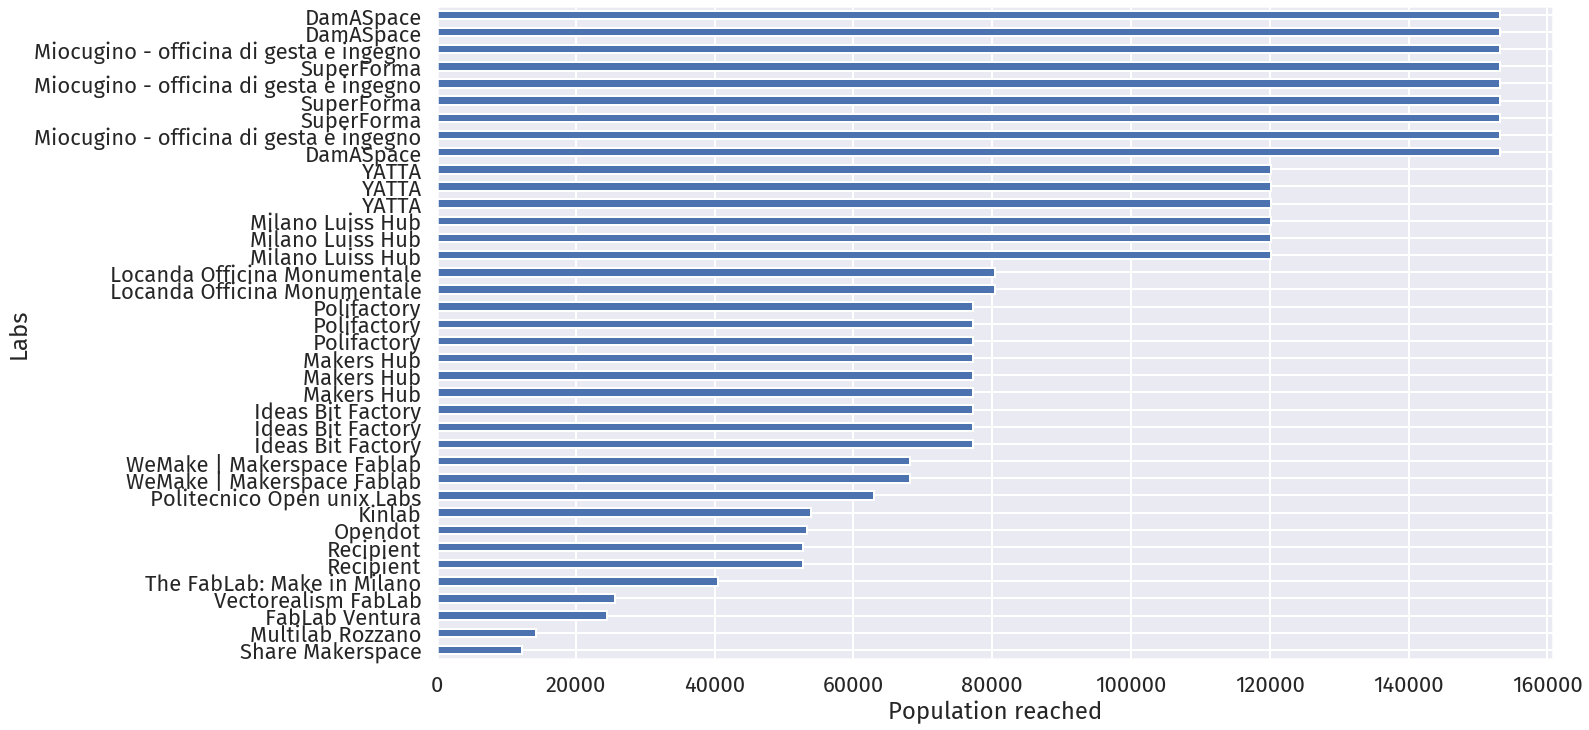

In [40]:
# Configure font
matplotlib.rcParams['font.sans-serif'] = "Fira Sans"
matplotlib.rcParams['font.family'] = "sans-serif"
sns.set_context("poster")
# Plot the data
labs_ita2 = labs_ita.set_index("name")
labs_ita2.sort_values(by=["population_fb"])["population_fb"].plot(kind="barh", figsize=(20,12))
plt.xlabel('Population reached')
plt.ylabel('Labs')
plt.savefig("svg/labs_ita_fbpop.svg", bbox_inches="tight")
plt.savefig("png/labs_ita_fbpop.png", dpi=300, bbox_inches="tight")